In [ ]:
import os
os.chdir(r'D:\ML\minor project')
print("Current working directory:", os.getcwd())

Current working directory: D:\ML\minor project


In [ ]:
import librosa
print(librosa.__version__)  # Should be ≥0.11.0


0.11.0


In [ ]:
import os
import soundfile as sf
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from audiomentations import Compose, AddGaussianNoise, PitchShift, TimeStretch

# Configuration
real_dir = r"D:\ML\minor project\archive\KAGGLE\AUDIO\REAL"
output_dir = r"D:\ML\minor project\archive\KAGGLE\SPECTROGRAMS\REAL_GEN"
os.makedirs(output_dir, exist_ok=True)

# Target dimensions and parameters
target_size = (173, 172)
sr = 22050
n_mels = 128
aug_per_file = 7

# Augmentation pipeline
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
])

def create_spectrogram(y, sr, save_path):
    """Convert audio to Mel-spectrogram matching original color scheme and size"""
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Calculate precise figure size to get 173x172 output
    fig = plt.figure(figsize=(target_size[0]/100, target_size[1]/100), dpi=100, frameon=False)

    # Match exact colormap from original
    librosa.display.specshow(S_dB, sr=sr, cmap='plasma')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0, dpi=100)
    plt.close()

    # Verify dimensions
    from PIL import Image
    img = Image.open(save_path)
    if img.size != target_size:
        img = img.resize(target_size)
        img.save(save_path)

# Only augmented files counter
generated_count = 0

# Process each original file
for file in os.listdir(real_dir):
    if file.lower().endswith('.wav'):
        base_name = os.path.splitext(file)[0]
        file_path = os.path.join(real_dir, file)

        # Load audio with soundfile
        y, orig_sr = sf.read(file_path)
        if y.ndim > 1:
            y = y.mean(axis=1)
        if orig_sr != sr:
            y = librosa.resample(y, orig_sr=orig_sr, target_sr=sr)

        # Generate exactly 7 augmentations per file (no originals)
        for i in range(aug_per_file):
            y_aug = augment(samples=y, sample_rate=sr)
            output_path = os.path.join(output_dir, f"{base_name}_aug_{i}.png")
            create_spectrogram(y_aug, sr, output_path)
            generated_count += 1

print(f"Generated exactly {generated_count} spectrograms (173x172px) in {output_dir}")


Generated exactly 56 spectrograms (173x172px) in D:\ML\minor project\archive\KAGGLE\SPECTROGRAMS\REAL_GEN


In [ ]:
# %% Enhanced Imports
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten,
                                   Dense, Dropout, BatchNormalization)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

# %% Configuration
SPECTROGRAM_PATH = r"D:\ML\minor project\archive\KAGGLE\SPECTROGRAMS"
IMG_SIZE = (224, 224)
BATCH_SIZE = 8  # Reduced for better batch coverage
EPOCHS = 100
CLASS_NAMES = ['FAKE', 'REAL']
VAL_SPLIT = 0.2

# %% Enhanced Data Pipeline
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VAL_SPLIT,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0
)

train_generator = train_datagen.flow_from_directory(
    SPECTROGRAM_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    classes=CLASS_NAMES,
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    SPECTROGRAM_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    classes=CLASS_NAMES,
    shuffle=False
)

# %% Proper Class Weight Calculation
def calculate_class_weights():
    class_counts = np.bincount(train_generator.classes)
    return {
        0: class_counts[1]/class_counts[0],  # FAKE weight
        1: class_counts[0]/class_counts[1]   # REAL weight
    }

CLASS_WEIGHTS = calculate_class_weights()
print(f"Effective class weights: {CLASS_WEIGHTS}")

# %% Simplified Model Architecture
def create_cnn_model():
    model = Sequential([
        Conv2D(16, (3,3), activation='relu', input_shape=(*IMG_SIZE, 3)),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
    )
    return model

# %% Training Configuration
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=30,
    min_delta=0.01,
    mode='max',
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

# %% Enhanced Evaluation with Path Verification
def evaluate_model():
    y_true = val_generator.classes
    y_pred_probs = model.predict(val_generator)
    y_pred = (y_pred_probs > 0.5).astype(int)

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, zero_division=0))

    # Confusion Matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(confusion_matrix(y_true, y_pred),
                annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title('Confusion Matrix')
    plt.savefig(os.path.abspath('confusion_matrix.png'), dpi=300, bbox_inches='tight')
    plt.close()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    roc_auc = roc_auc_score(y_true, y_pred_probs)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig(os.path.abspath('roc_curve.png'), dpi=300, bbox_inches='tight')
    plt.close()

    print("\nVisualizations saved to:")
    print(f"- {os.path.abspath('confusion_matrix.png')}")
    print(f"- {os.path.abspath('roc_curve.png')}")

    return model.evaluate(val_generator)

# %% Main Execution
if __name__ == "__main__":
    # Verify dataset
    print(f"Training samples: {train_generator.samples}")
    print(f"Validation samples: {val_generator.samples}")

    # Model initialization
    model = create_cnn_model()

    # Calculate steps with ceiling
    steps_per_epoch = np.ceil(train_generator.samples / BATCH_SIZE).astype(int)
    val_steps = np.ceil(val_generator.samples / BATCH_SIZE).astype(int)

    # Training
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_generator,
        validation_steps=val_steps,
        epochs=EPOCHS,
        callbacks=[early_stop, checkpoint],
        class_weight=CLASS_WEIGHTS,
        verbose=1
    )

    # Final evaluation
    model = tf.keras.models.load_model('best_model.keras')
    evaluate_model()


Found 90 images belonging to 2 classes.
Found 22 images belonging to 2 classes.
Effective class weights: {0: 1.0, 1: 1.0}
Training samples: 90
Validation samples: 22


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 242ms/step - accuracy: 0.7865 - loss: 0.7273 - precision: 0.7366 - recall: 0.8652 - val_accuracy: 0.5000 - val_loss: 0.9594 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.9353 - loss: 0.1866 - precision: 0.9425 - recall: 0.9243 - val_accuracy: 0.5000 - val_loss: 0.8649 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.9871 - loss: 0.0474 - precision: 0.9860 - recall: 0.9884 - val_accuracy: 0.5000 - val_loss: 1.0052 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.9453 - loss: 0.2208 - precision: 0.9682 - recall: 0.9333 - val_accuracy: 0.5000 - val_loss: 1.1734 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.9571 - loss: 0.1942 - precision: 0.9497 - recall: 0.9757 - val_accuracy: 0.5000 - val_los

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step

Classification Report:
              precision    recall  f1-score   support

        FAKE       1.00      1.00      1.00        11
        REAL       1.00      1.00      1.00        11

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22


Visualizations saved to:
- D:\ML\minor project\confusion_matrix.png
- D:\ML\minor project\roc_curve.png
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 0.0349 - precision: 0.7500 - recall: 0.7500


Found 90 images belonging to 2 classes.
Found 22 images belonging to 2 classes.


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.6249 - loss: 0.6436 - precision: 0.6412 - recall: 0.5981

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6266 - loss: 0.6439 - precision: 0.6424 - recall: 0.6037 - val_accuracy: 0.5625 - val_loss: 0.6702 - val_precision: 0.5000 - val_recall: 0.7143
Epoch 2/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.8750 - loss: 0.5837 - precision: 0.7778 - recall: 1.0000

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.8750 - loss: 0.5837 - precision: 0.7778 - recall: 1.0000 - val_accuracy: 0.6875 - val_loss: 0.6844 - val_precision: 0.7000 - val_recall: 0.7778
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.7216 - loss: 0.5665 - precision: 0.7677 - recall: 0.6631

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 509ms/step - accuracy: 0.7275 - loss: 0.5623 - precision: 0.7721 - recall: 0.6710 - val_accuracy: 0.8125 - val_loss: 0.5201 - val_precision: 0.7500 - val_recall: 0.8571
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.7500 - loss: 0.5065 - precision: 0.8000 - recall: 0.5714 - val_accuracy: 0.8125 - val_loss: 0.5521 - val_precision: 0.8571 - val_recall: 0.7500
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8722 - loss: 0.4657 - precision: 0.9251 - recall: 0.7867

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 473ms/step - accuracy: 0.8710 - loss: 0.4653 - precision: 0.9314 - recall: 0.7794 - val_accuracy: 0.8750 - val_loss: 0.4163 - val_precision: 1.0000 - val_recall: 0.7500
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.9375 - loss: 0.4347 - precision: 0.9091 - recall: 1.0000 - val_accuracy: 0.7500 - val_loss: 0.4566 - val_precision: 0.7143 - val_recall: 0.7143
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 412ms/step - accuracy: 0.9436 - loss: 0.3431 - precision: 0.9764 - recall: 0.9043 - val_accuracy: 0.8750 - val_loss: 0.4380 - val_precision: 1.0000 - val_recall: 0.7500
Epoch 8/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.7000 - loss: 0.6275 - precision: 1.0000 - recall: 0.5714

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.7000 - loss: 0.6275 - precision: 1.0000 - recall: 0.5714 - val_accuracy: 1.0000 - val_loss: 0.3082 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 426ms/step - accuracy: 0.9389 - loss: 0.3063 - precision: 1.0000 - recall: 0.8759 - val_accuracy: 1.0000 - val_loss: 0.3270 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.8750 - loss: 0.3139 - precision: 1.0000 - recall: 0.8333 - val_accuracy: 0.8750 - val_loss: 0.3309 - val_precision: 0.8889 - val_recall: 0.8889
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 412ms/step - accuracy: 0.8800 - loss: 0.3039 - precision: 0.9567 - recall: 0.8120 - val_accuracy: 1.0000 - val_loss: 0.2344 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 1.0000 - loss: 0.1864 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9375 - val_loss: 0.2763 - val_precisi

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.75      1.00      0.85        56
        REAL       1.00      0.66      0.80        56

    accuracy                           0.83       112
   macro avg       0.87      0.83      0.83       112
weighted avg       0.87      0.83      0.83       112



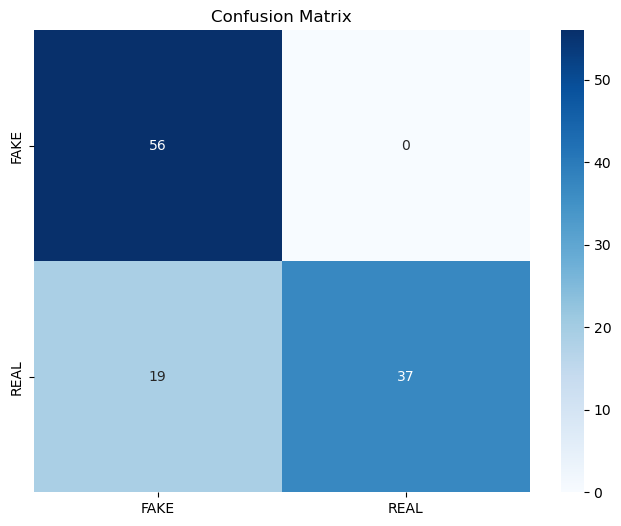

In [ ]:
"""
Audio Deepfake Detection using Transfer Learning
"""

# %% Imports
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# %% Configuration
SPECTROGRAM_PATH = r"D:\ML\minor project\archive\KAGGLE\SPECTROGRAMS"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 50
CLASS_NAMES = ['FAKE', 'REAL']

# %% Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8,1.2],
    horizontal_flip=True,
    fill_mode='constant',
    cval=0
)

# %% Data Generators
def create_generator(datagen, subset):
    return datagen.flow_from_directory(
        SPECTROGRAM_PATH,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset=subset,
        classes=CLASS_NAMES,
        color_mode='rgb'  # Pretrained models need 3 channels
    )

train_generator = create_generator(train_datagen, 'training')
val_generator = create_generator(train_datagen, 'validation')

# %% Class Weight Calculation
class_counts = train_generator.classes.sum(), len(train_generator.classes) - train_generator.classes.sum()
total = sum(class_counts)
CLASS_WEIGHTS = {0: total/(2*class_counts[0]), 1: total/(2*class_counts[1])}

# %% Model Setup
def create_transfer_model():
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(*IMG_SIZE, 3)
    )

    # Freeze base layers
    base_model.trainable = False

    # Add custom head
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

model = create_transfer_model()

# %% Model Compilation
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# %% Callbacks
callbacks = [
    EarlyStopping(monitor='val_recall', patience=10, mode='max', restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
]

# %% Training
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=CLASS_WEIGHTS
)

# %% Evaluation
def evaluate_model():
    test_datagen = ImageDataGenerator(rescale=1./255)

    test_generator = test_datagen.flow_from_directory(
        SPECTROGRAM_PATH,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False,
        classes=CLASS_NAMES
    )

    # Load best model
    model = tf.keras.models.load_model('best_model.h5')

    # Generate predictions
    y_true = test_generator.classes
    y_pred = (model.predict(test_generator) > 0.5).astype(int)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()

evaluate_model()

# %% Prediction Function
def predict_spectrogram(img_path):
    img = tf.keras.preprocessing.image.load_img(
        img_path,
        target_size=IMG_SIZE,
        color_mode='rgb'
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    prediction = model.predict(img_array)[0][0]
    return "FAKE" if prediction > 0.5 else "REAL"

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

# Configuration
DATA_DIR = r"D:\ML\minor project\archive\KAGGLE\SPECTROGRAMS"
IMG_SIZE = (173, 172)
BATCH_SIZE = 8
EPOCHS = 100
CLASS_NAMES = ['FAKE', 'REAL']
VAL_SPLIT = 0.2

# Data Pipeline
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VAL_SPLIT,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='constant'
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    classes=CLASS_NAMES,
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    classes=CLASS_NAMES,
    shuffle=False
)

# Model Architecture
def create_model():
    base_model = MobileNetV2(
        input_shape=(*IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )

    # Freeze initial layers
    for layer in base_model.layers[:-4]:
        layer.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss='binary_crossentropy',
        metrics=['accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
    )
    return model

# Training Configuration
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ModelCheckpoint('best_spectrogram_model.keras', save_best_only=True)
]

# Model Training
model = create_model()
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks
)

# Evaluation and Visualization
def generate_evaluation():
    # Generate predictions
    y_true = val_generator.classes
    y_pred_probs = model.predict(val_generator)
    y_pred = (y_pred_probs > 0.5).astype(int)

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

    # Confusion Matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(confusion_matrix(y_true, y_pred),
                annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.close()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    roc_auc = roc_auc_score(y_true, y_pred_probs)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
    plt.close()

    # Training History
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.close()

    print("\nEvaluation visualizations saved:")
    print("- confusion_matrix.png")
    print("- roc_curve.png")
    print("- training_history.png")

generate_evaluation()


Found 90 images belonging to 2 classes.
Found 22 images belonging to 2 classes.


C:\Users\HP\AppData\Local\Temp\ipykernel_21340\2105770840.py:56: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Epoch 1/100


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 406ms/step - accuracy: 0.4749 - loss: 1.0200 - precision: 0.3315 - recall: 0.0888 - val_accuracy: 0.6875 - val_loss: 0.5625 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.6250 - loss: 0.7749 - precision: 1.0000 - recall: 0.2500

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.6250 - loss: 0.7749 - precision: 1.0000 - recall: 0.2500 - val_accuracy: 0.6875 - val_loss: 0.5294 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.6083 - loss: 0.7698 - precision: 0.4321 - recall: 0.2228 - val_accuracy: 0.6875 - val_loss: 0.5729 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7500 - loss: 0.5485 - precision: 1.0000 - recall: 0.3333 - val_accuracy: 0.6875 - val_loss: 0.6127 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.5130 - loss: 0.8303 - precision: 0.7037 - recall: 0.2469 - val_accuracy: 0.7500 - val_loss: 0.4833 - val_precision: 1.0000 - val_recall: 0.2000
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6250 - loss: 0.6372 - precision: 1.0000 - recall: 0.4000 - val_accuracy: 0.6875 

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 719ms/step

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.73      1.00      0.85        11
        REAL       1.00      0.64      0.78        11

    accuracy                           0.82        22
   macro avg       0.87      0.82      0.81        22
weighted avg       0.87      0.82      0.81        22


Evaluation visualizations saved:
- confusion_matrix.png
- roc_curve.png
- training_history.png
